# Python for Data Science 
## CourserWork October 2020

## The theme chosen for this project has been: 

<h1>Markup Language</h1>
<p>Projects should focus on exploring markup from one or more of the top 50 websites, according to Alexa. </p>
<p>‘An analysis of the semantic features of streaming websites.’</p>

The first thing we need to do is to get the information from the URL: https://www.alexa.com/topsites/countries/GB. Where the top 50 websites for the UK are listed. This analyisis intends to find any correlation between being a top site and having an specific DOM (Document Element) structure. 

To fetch the information from this website (an all further websites), the libraries `requests` and `BeautifulSoup` have been used. 

In [3]:
# ------------------------------
# Required packages in order for the script to run without problems. 

%pip install -r requirements.txt

# ------------------------------

from bs4 import BeautifulSoup
import requests
from itertools import islice

url = 'https://www.alexa.com/topsites/countries/GB'
html = requests.get(url)
parsedHtml = BeautifulSoup(html.text, features='html.parser')


Note: you may need to restart the kernel to use updated packages.


If one looks now at the structure of the website of Alexa, all the websites are listed in the following html structure: 

```html
<div class='td DescriptionCell'>
    <p>
        <a/> <- Link to the page   
    </p>
</div>
```
Therefore one can search for all the html tags with class 'td DescriptionCell', and then inside, for an ```<a>``` tag which allows us to list all the webstie from Alexa



In [4]:

urlAlexa = 'https://www.alexa.com'
containersList = parsedHtml.find_all('div', class_='td DescriptionCell')

containersList

websitesDict= {}

for container in containersList:
    pDiv = container.find('p')
    websitesDict[pDiv.text.strip().replace('\n', '')] = urlAlexa + pDiv.find('a')['href']



Now we have stored in this dictionary with the following information:

The keys of `websitesDict` are filled with the  name of the website, as saved by the Alexa ranking (already treated with split and replace), while the value of each key contains the alexa link redirecting to the ifnormation Alexa stores of that given url

Let's see the first 10 items of the dictionary:



In [5]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
    
print(take(5,websitesDict.items()))

[('Google.com', 'https://www.alexa.com/siteinfo/google.com'), ('Youtube.com', 'https://www.alexa.com/siteinfo/youtube.com'), ('Reddit.com', 'https://www.alexa.com/siteinfo/reddit.com'), ('Amazon.co.uk', 'https://www.alexa.com/siteinfo/amazon.co.uk'), ('Google.co.uk', 'https://www.alexa.com/siteinfo/google.co.uk')]


It can be seen that within this dictonary, there are some websites that may contain some sensitive content, and therefore must be excluded from this study. 
In order to detect which websites have sensitive content, we can fetch the website listed in the values of the dictionary `websitesDict`. In this Alexa website we will be able to find several information about the specified website which will help to decide wether to include or exclude the website.

If one analyses the markup tags of this page, they will find that there are `keywords`, which contain important words that people use to decribe these sites. Therefore, we'll use these keywords in order to filter the top 50 websites.

They way to determine if a website is sensitive-content free has been to use a list of sensitive words (`filterWords`), and match the obtained `keywords` of the site to match any of these sensitive words. It a match is found, then the website is removed from the analysis.  

In [6]:
import re

def getWebsiteKeywords(url: str, kewyWordsDict: dict) -> dict:
    """
    This function fetches the given url and filters
    the html tags in order to obtain the keywords
    for the Alexa index page
    """
    keywordsList = []
    html = requests.get(url)
    parsedHtml = BeautifulSoup(html.text, features='html.parser')
    allKeyWords = parsedHtml.find_all('div', class_='keyword')
    for keyWord in allKeyWords[1:6]:
        specWords = keyWord.find('span', class_='truncation')
        keywordsList.append(specWords.text)
    kewyWordsDict[url] = keywordsList
    return kewyWordsDict

# Declare empty initial dictionary
keyWordsDict = {}

# fill dictionary with the structure {'site': [keywords]}
for site in websitesDict:
    keyWordsDict = getWebsiteKeywords(websitesDict[site], keyWordsDict)


def filterList(keyWordsDict: dict, websitesDict: dict) -> list:
    """
    This function receives the dictionary of structure: {'alexaSite': [keywords]}
    and, if the keywords contain any of the words in 'filterWords', removes the entry 
    from the dictionary: {'site': 'alexaSite'} 
    """
    filteredList = []
    filterWords = ['sex', 'porn', 'cam', 'violence', 'sex cam', 'live sex', 'office 365 login', 'uncensored mcdonalds fight']
    for entry in websitesDict:
        #if any(word in keyWordsDict[websitesDict[entry]] for word in filterWords):
        if any(re.match(f'.*{word}.*', keyWord) for word in filterWords for keyWord in keyWordsDict[websitesDict[entry]]):
            pass
            #TODO: Do some actions with the not matches websites (print message, exception, etc.)
        else: 
            filteredList.append(entry)
    return filteredList

    
filteredList = filterList(keyWordsDict, websitesDict)

# Filtered List
Now he have the filtered list, we can start fetching the sensitive-content free websites in order to begin analysing the inner HTML structure of the pages, as well as other metrics, such as wordcount, imagecount, and more.

For this, we'll fetch every url as `https://www.{site}`, then treat the information obtained and store everythng in a pandas DataFrame in order to be able to handle information much more easily

## Limitations of this method and get-arounds

Obviously, this method has some limitations when it comes to analysing the content of a website by its tags. Some websites, as *Youtube* return an html that has only `div` elements, and all the videos and images we are used to see have to be found in some other way (if a real statistic wants to be extracted). In this specific case, the html has been treated by analysing the structure returned by the `requests` class and counting the images that are really in the website.

In a wider project, all the desired websites would have been analysed one by one, or using other techniques (not relying in the html tags).

In [7]:
import pandas as pd 
import os
pd.set_option('display.max_columns', None)

columns = ['p', 'span', 'div', 'img', 'video', 'nav','a','table','form','button']
mainDF = pd.DataFrame(columns=columns)


def getUrlInfoIntoDF(url: str, mainDF: pd.DataFrame) -> pd.DataFrame: 
    """
    Fetches the url given as an input and obtains information of the webpage.
    This information is put into a DataFrame object.
    """
    try: 
        html = requests.get('https://www.' + url)
        parsedHtml = BeautifulSoup(html.text, features='html.parser')
        #Insert new row to DF
        row = pd.Series([0]*len(mainDF.columns.tolist()))
        row_df = pd.DataFrame(columns=mainDF.columns, data=[row], index = [url])
        mainDF = pd.concat([row_df, mainDF])

        for col in columns:
            if col=='a':
                all_elements = parsedHtml.find_all(col, href=True)
            else:
                all_elements = parsedHtml.find_all(col)
            count = 0
            wordCount = 0
            linkCount = 0
            
            for el in all_elements:
                count = count + 1
                wordCount = wordCount + len(el.text.split())
                if col == 'a' and el['href']:
                    linkCount = linkCount + 1

            #print(f'There are {count} of the type {col} in the website {url}, with a total length of {wordCount} words, and {linkCount} links.')
            
            
            #This is a special treatment for youtube beautiful soup, that returns an html with no content (everything is in the script tag)
            if col=='img' and re.match('.*Youtube.*', url):
                all_text = parsedHtml.find_all('script')
                img_tot = 0
                for text in all_text:
                    if len(text.contents) > 0:
                        img = len(re.findall('ytimg', text.contents[0]))
                        img_tot = img_tot + img
                count = img_tot
                
            #Add column of wordcount for each html tag to DataFrame.
            wordcol = f'{col}_wordcount'
            mainDF.loc[url, col] = count
            mainDF.loc[url, wordcol] = wordCount
            if (linkCount > 0):
                mainDF.loc[url, 'links'] = linkCount
    except Exception as e:
        print(f'Error while scanning: {e}')        
    finally:
        return mainDF

    
for url in filteredList:
    mainDF = getUrlInfoIntoDF(url, mainDF)

mainDF.head()



Error while scanning: HTTPSConnectionPool(host='www.www.gov.uk', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9b13f16b70>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))


,p,span,div,img,video,nav,a,table,form,button,p_wordcount,span_wordcount,div_wordcount,img_wordcount,video_wordcount,nav_wordcount,a_wordcount,links,table_wordcount,form_wordcount,button_wordcount
Currys.co.uk,26,12,61,51,0,1,222,1,0,0,298.0,22.0,3601.0,33.0,0.0,69.0,673.0,222.0,0.0,0.0,0.0
Unilad.co.uk,0,6,78,63,0,2,219,0,1,2,0.0,1.0,3469.0,0.0,0.0,22.0,731.0,219.0,0.0,1.0,1.0
Amazon.com,0,0,3,3,0,0,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
T.co,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
Duckduckgo.com,0,2,15,0,0,0,2,0,1,0,0.0,4.0,48.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0


# Exploring the data

Now that we have the desired data in a treatable format (in this case a Pandas Dataframe, `mainDF`), we can begin extracting some information out of it. 

First, we can extract some statistical measures of all the columns of the DF. Another thing we can do is check if the information has been **registerd** in the DF correctly, by viewing the data types and null contents of the websites. 



In [8]:
mainDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, Currys.co.uk to Google.com
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   p                 41 non-null     object 
 1   span              41 non-null     object 
 2   div               41 non-null     object 
 3   img               41 non-null     object 
 4   video             41 non-null     object 
 5   nav               41 non-null     object 
 6   a                 41 non-null     object 
 7   table             41 non-null     object 
 8   form              41 non-null     object 
 9   button            41 non-null     object 
 10  p_wordcount       41 non-null     float64
 11  span_wordcount    41 non-null     float64
 12  div_wordcount     41 non-null     float64
 13  img_wordcount     41 non-null     float64
 14  video_wordcount   41 non-null     float64
 15  nav_wordcount     41 non-null     float64
 16  a_wordcount       41 non-null   

As we can see, there are areound 40 entries in the dataframe (depending ont he connection state of the websites in the moment of scraping), with a total of 19 columns. 

## Null values 
Of these entries, there are null values in the column *links*, beacuse there have been some pages that have not contained any *a* tag element, and therefore this column has not been filled. These columns have to be changed to 0, in order to be able to obtain a good statistical measure of the sites. Once this is done, the other results, with no null-values can confirm that the treatment we have given to the data has been correct, at least to the point of not obtaining null values in the data set.  As we have stored only float and integers, the size of the data set does not exceed 8 KB. 

## Data types to float
Next, we can obtain the main statistical information about the columns, like the mean, median, standard deviation, etc. For this, first we have to parse all the types into numeric types. As one can see, the first columns (the html tags) are stored as object types. These columns must be changed into floats, in order to be able to compute the most important statistic features

In [9]:
mainDF['links'] = mainDF['links'].fillna(0)
dfTypes = dict(mainDF.dtypes)

for col in mainDF.columns:
    if dfTypes[col] != 'float64':
        mainDF = mainDF.astype({col: float})

mainDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, Currys.co.uk to Google.com
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   p                 41 non-null     float64
 1   span              41 non-null     float64
 2   div               41 non-null     float64
 3   img               41 non-null     float64
 4   video             41 non-null     float64
 5   nav               41 non-null     float64
 6   a                 41 non-null     float64
 7   table             41 non-null     float64
 8   form              41 non-null     float64
 9   button            41 non-null     float64
 10  p_wordcount       41 non-null     float64
 11  span_wordcount    41 non-null     float64
 12  div_wordcount     41 non-null     float64
 13  img_wordcount     41 non-null     float64
 14  video_wordcount   41 non-null     float64
 15  nav_wordcount     41 non-null     float64
 16  a_wordcount       41 non-null   

As we can see, the type of the columns has changed (as well as having all non-null values in the *Links* column), and now Pandas can *see* that they are of numeric type. With this change, the statistic values can be computed. 

In [10]:
mainDF.describe(include='all')

,p,span,div,img,video,nav,a,table,form,button,p_wordcount,span_wordcount,div_wordcount,img_wordcount,video_wordcount,nav_wordcount,a_wordcount,links,table_wordcount,form_wordcount,button_wordcount
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.0,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,16.878049,147.146341,290.073171,55.731707,0.048780,0.609756,136.634146,0.414634,0.975610,10.024390,289.024390,564.487805,9224.414634,1.487805,0.0,20.024390,691.609756,136.560976,5.902439,26.195122,9.146341
std,29.182354,297.748767,338.838191,159.458462,0.312348,1.045898,177.876327,1.071812,0.907959,24.432036,801.680032,1645.518188,24924.545505,5.683845,0.0,52.042044,2088.957274,177.910237,22.991091,99.720414,18.521016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,38.000000,2.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,12.000000,479.000000,0.000000,0.0,0.000000,31.000000,21.000000,0.000000,0.000000,0.000000
50%,2.000000,32.000000,132.000000,24.000000,0.000000,0.000000,87.000000,0.000000,1.000000,2.000000,28.000000,106.000000,3469.000000,0.000000,0.0,0.000000,200.000000,87.000000,0.000000,2.000000,1.000000
75%,17.000000,158.000000,453.000000,54.000000,0.000000,1.000000,169.000000,0.000000,1.000000,6.000000,259.000000,327.000000,7899.000000,0.000000,0.0,8.000000,565.000000,169.000000,0.000000,7.000000,8.000000
max,115.000000,1652.000000,1488.000000,1029.000000,2.000000,4.000000,958.000000,4.000000,3.000000,112.000000,4955.000000,10252.000000,158675.000000,33.000000,0.0,246.000000,13301.000000,958.000000,108.000000,623.000000,102.000000


# Total words per website

Now an analysisi of the total words per site will be performed, taking into account the count of all the columns that have the word *wordcount* on it, since we stored in these columns the wordcounts of the different tags.

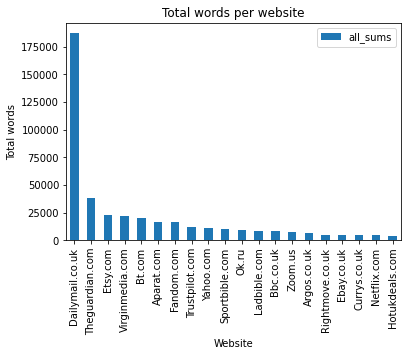

In [30]:
mainDF.head()

import matplotlib.pyplot as plt

wordcountColumns = list()
[wordcountColumns.append(col) for col in mainDF.columns.to_list() if re.match('.*wordcount.*', col)]
sum_column = 0
for col in wordcountColumns:
    sum_column = mainDF[col] + sum_column
    
mainDF['all_sums'] = sum_column

mainDF.sort_values(by=['all_sums'], ascending=False).head(20).plot.bar(y='all_sums')
plt.xlabel("Website")
plt.ylabel("Total words")
plt.title("Total words per website")
plt.show()

# Total tags per page


The site *Dailymail.co.uk* is, by far, the site with the most words. If one takes a look at the site, they can clearly see why. This is due to the fact that the website of *Dailymail.co.uk* is a single page, 'infinite' scrolling site. Being this, the html obtained with the `requests` library contains a very large html page, with far more divs than a normal website. To see if this is the case, one can sum all the html tags obtained in the sites (as we have done with the wordcounts for each tag) and find which site has the most tags.

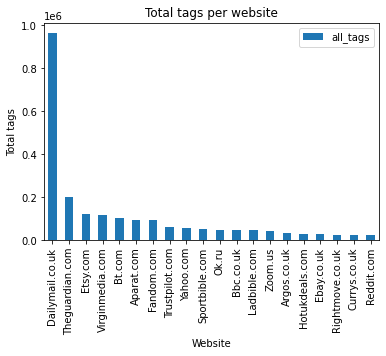

In [29]:
wordcountColumns = list()
# Generate a list of the columns that contain 'wordcount'
[wordcountColumns.append(col) for col in mainDF.columns.to_list() if not re.match('.*wordcount.*', col)]
sum_column = 0
# Sum all the values of the columns into a single column
for col in wordcountColumns:
    sum_column = mainDF[col] + sum_column

mainDF['all_tags'] = sum_column

mainDF.sort_values(by=['all_tags'], ascending=False).head(20).plot.bar(y='all_tags')
plt.xlabel("Website")
plt.ylabel("Total tags")
plt.title("Total tags per website")
plt.show()

# Number of words per html tag
Another useful thing to display is a scatter plot of the total wordcount vs. the total number of tags found. Let's observe the result. It is to say that the two sites with the highest wordcount have been removed from the figure to be able to visualise things more clearly: 

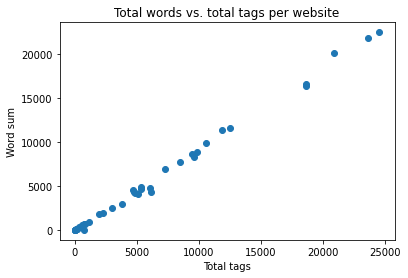

In [23]:
plt.scatter(mainDF.drop(['Dailymail.co.uk','Theguardian.com'], axis=0).all_tags, mainDF.drop(['Dailymail.co.uk','Theguardian.com'], axis=0).all_sums)
plt.xlabel("Total tags")
plt.ylabel("Word sum")
plt.title("Total words vs. total tags per website")

plt.show()

As we can see, the number of words per tag follows a lineal rule, and all the websites lie roughly within a straight line. 

# Media tags in the websites

Some tags contain special content, like pictures or videos. These tags have been stored in 'img' or 'video' columns. If we take a first look to these columns, with an stacked bar plot, we see the following results: 

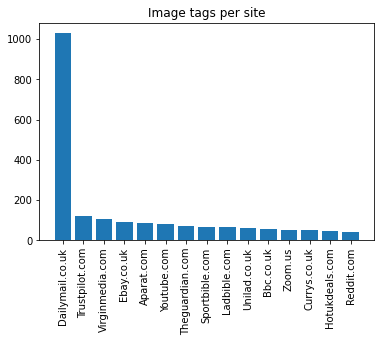

In [14]:
plt.bar(mainDF.sort_values(by=['img'], ascending=False).head(15).index, mainDF.sort_values(by=['img'], ascending=False).head(15)['img'])
plt.xticks(rotation=90)
plt.title('Image tags per site')
plt.show()

As we can see, the page with the most media tags is *Dailymail.co.uk*. Of course, these numbers are high because of the fact that the page is much longer than the other pages. This may be true for other pages too. Therefore, in order to ditinguish how important media tags are in a given site, we will divide the media tags, such as 'img' or 'video' by the total amount of tags (like an specific ratio).
This process gives the following results: 

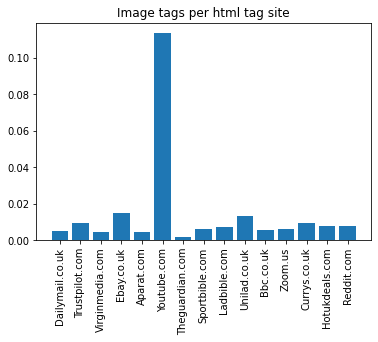

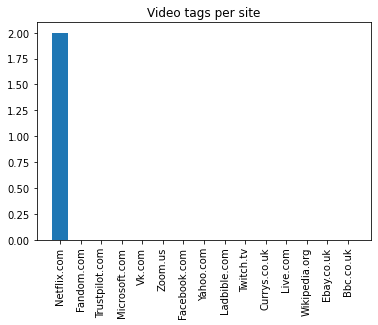

In [15]:

plt.bar(mainDF.sort_values(by=['img'], ascending=False).head(15).index, mainDF.sort_values(by=['img'], ascending=False).head(15)['img']/mainDF.sort_values(by=['img'], ascending=False).head(15)['all_tags'])
plt.xticks(rotation=90)
plt.title('Image tags per html tag site')
plt.show()

plt.bar(mainDF.sort_values(by=['video'], ascending=False).head(15).index, mainDF.sort_values(by=['video'], ascending=False).head(15)['video'])
plt.xticks(rotation=90)
plt.title('Video tags per site')
plt.show()

It can be seen now that the website *Youtube* contains the most *img* tags per tag contained, and the website *Netflix* (and others, depending on when the code is run) are the only ones on the list to contain actual *video* tags and not image tags that lead to videos.

# 

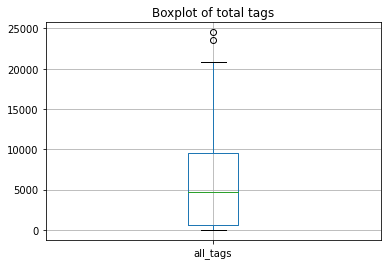

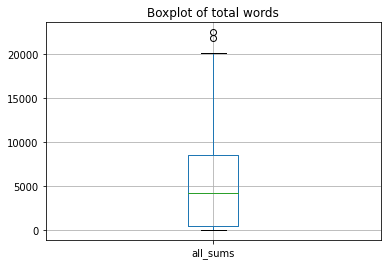

In [24]:

mainDF.drop(['Dailymail.co.uk','Theguardian.com'], axis=0).boxplot(column='all_tags')
plt.title('Boxplot of total tags')
plt.show()
mainDF.drop(['Dailymail.co.uk','Theguardian.com'], axis=0).boxplot(column='all_sums')
plt.title('Boxplot of total words')
plt.show()

Obviously, the one outlier we have found is the website `Dailymail.co.uk`, which has the longest website of the list. Another thing we can extract from these figures is that there are some websites with very high `wordcounts` and `tagscounts`. Furthermore, most of the websites lie within a common range (the 25th-75th percentile), while there are some that have almost double the words, or double the html tags.

# Number of href of the websites

Another important feature of the sites is how many links to other pages they contain. In order to observe this, one can take a look at the `a` tags of the websites found.


In [17]:
mainDF.sort_values(by='a', ascending=False).head(10)

,p,span,div,img,video,nav,a,table,form,button,p_wordcount,span_wordcount,div_wordcount,img_wordcount,video_wordcount,nav_wordcount,a_wordcount,links,table_wordcount,form_wordcount,button_wordcount,all_sums,all_tags
Dailymail.co.uk,98.0,1652.0,813.0,1029.0,0.0,0.0,958.0,1.0,1.0,21.0,4955.0,10252.0,158675.0,5.0,0.0,0.0,13301.0,958.0,0.0,7.0,21.0,187216.0,192747.0
Etsy.com,87.0,359.0,678.0,40.0,0.0,2.0,425.0,0.0,3.0,28.0,620.0,509.0,19140.0,13.0,0.0,39.0,1489.0,425.0,0.0,623.0,40.0,22473.0,24520.0
Theguardian.com,3.0,512.0,1009.0,72.0,0.0,1.0,410.0,0.0,1.0,19.0,59.0,2515.0,32289.0,0.0,0.0,204.0,2849.0,410.0,0.0,10.0,37.0,37963.0,40400.0
Ebay.co.uk,50.0,116.0,386.0,92.0,0.0,0.0,334.0,4.0,1.0,23.0,65.0,327.0,3420.0,0.0,0.0,0.0,780.0,334.0,100.0,6.0,36.0,4734.0,6074.0
Wikipedia.org,2.0,58.0,85.0,1.0,0.0,0.0,323.0,0.0,1.0,2.0,38.0,106.0,2177.0,0.0,0.0,0.0,536.0,323.0,0.0,101.0,6.0,2964.0,3759.0
Fandom.com,0.0,71.0,1488.0,10.0,0.0,0.0,314.0,0.0,2.0,2.0,0.0,122.0,14957.0,0.0,0.0,0.0,1298.0,314.0,0.0,2.0,0.0,16379.0,18580.0
Aparat.com,0.0,563.0,736.0,86.0,0.0,0.0,298.0,0.0,0.0,11.0,0.0,1501.0,14076.0,0.0,0.0,0.0,1063.0,298.0,0.0,0.0,2.0,16642.0,18634.0
Currys.co.uk,26.0,12.0,61.0,51.0,0.0,1.0,222.0,1.0,0.0,0.0,298.0,22.0,3601.0,33.0,0.0,69.0,673.0,222.0,0.0,0.0,0.0,4696.0,5292.0
Unilad.co.uk,0.0,6.0,78.0,63.0,0.0,2.0,219.0,0.0,1.0,2.0,0.0,1.0,3469.0,0.0,0.0,22.0,731.0,219.0,0.0,1.0,1.0,4225.0,4815.0
Virginmedia.com,66.0,232.0,926.0,108.0,0.0,0.0,213.0,4.0,2.0,3.0,661.0,481.0,19879.0,0.0,0.0,0.0,565.0,213.0,108.0,139.0,6.0,21839.0,23606.0


Of course, the website with the most `a` tags is the site *Dailymail.co.uk*, since is the site with the highest tag count. In order to know the importance of the `a` tags, as done with the images, one should look for the *specific a count*. That is, the total `a` count divided by the total tag count.



In [18]:
columnDF = mainDF.sort_values(by=['a'], ascending=False).head(15)['a']/mainDF.sort_values(by=['a'], ascending=False).head(15)['all_tags']
columnDF.sort_values(ascending=False)

Wikipedia.org      0.085927
Ebay.co.uk         0.054988
Unilad.co.uk       0.045483
Currys.co.uk       0.041950
Hotukdeals.com     0.027723
Rightmove.co.uk    0.026956
Zoom.us            0.019126
Etsy.com           0.017333
Fandom.com         0.016900
Aparat.com         0.015992
Ok.ru              0.015475
Trustpilot.com     0.011579
Theguardian.com    0.010149
Virginmedia.com    0.009023
Dailymail.co.uk    0.004970
dtype: float64

We can see now that the site with the most links are *Wikipedia*, *Ebay* and *Unilad*. These sites are websites that offer a lot of information to other sites. In *Wikipedia*, there are several links to other Wikipedia entries and every image leads to new windows. In the website *Ebay*, all the products displayed in the site link to other pages, showing the product information. In the case of *Unilad*, the portal offers access to lots of news, each one referrencing to another website. 

# TF-IDF of the whole corpus
## The last thing to do with these websites, and as further work is to obtain the TF-IDF transforms of the whole websites. With this, one can see if these websites have similar threads or they are completely approaching different topics.

For this, one can use the from sklearn library, the classes `TfidfVectorizer` and `CountVectorizer`.
The class `CountVectorizer` is used in order to obtain the wordcounts of the websites and the class `TfiDFVectorizer` is used in order to obtain the TF-IDF transform and the distance between the websites.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial                   import distance_matrix
from scipy.spatial.distance          import pdist, squareform

corpus = []

def getCorups(url: str, corpus: list) -> list:
    """
    Given an URL, this function obtains all the text from the website
    and then stores it in the list 'corpus' and returns this list. 
    """
    try: 
        url = 'https://www.' + url
        htmlText = requests.get(url).text
        parsedText = BeautifulSoup(htmlText, features='html.parser')
        allDocumentText = ''
        
        #Get rid of all the script and style tags
        for script in parsedText(["script", "style"]):
            script.extract()
            
        #Get the remaining text
        text = parsedText.get_text()
        corpus.append(text)
    except Exception as e:
        print(f'Error while scanning website {url}: ', e)
    finally: 
        return corpus

for url in mainDF.index.tolist():
    corpus = getCorups(url, corpus)

vectorizer = CountVectorizer()

wordscounts = vectorizer.fit_transform(corpus).toarray()

corpusDF = pd.DataFrame(data=squareform(pdist(wordscounts)), index=mainDF.index.tolist(), columns=mainDF.index.tolist())





# Term Frequency

Now that the dataframe `corpusDF`contains all the information of the term frequency, one can plot the obtained reuslts. To do so, the 

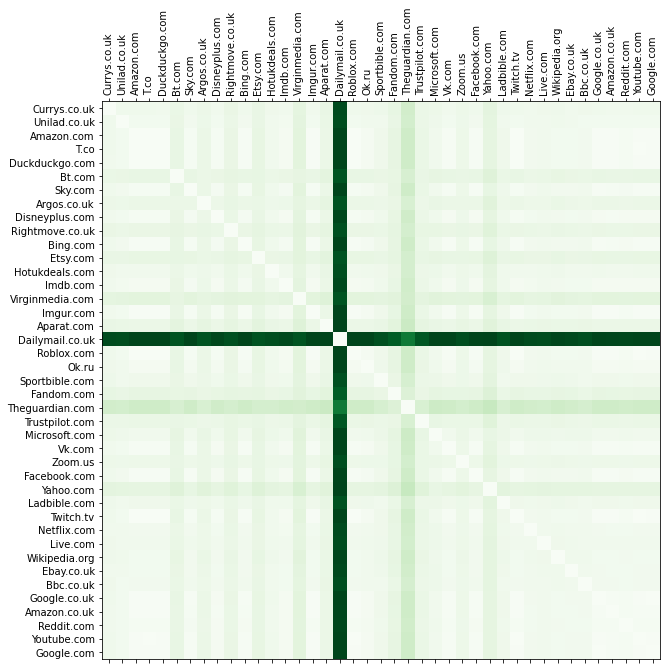

In [20]:
import numpy as np

plt.figure(figsize=(10,10))
plt.matshow(corpusDF,cmap="Greens", fignum=1)
ticks = [idx for idx, value in enumerate(corpusDF.index.tolist())]
ax = plt.gca()
xlabels = [txt for i,txt in enumerate(corpusDF.index.tolist())]
ylabels = [txt for i,txt in enumerate(corpusDF.index.tolist())]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)
plt.xticks(np.arange(min(ticks), max(ticks)+1, 1.0))
plt.yticks(np.arange(min(ticks), max(ticks)+1, 1.0))
plt.xticks(rotation=90)


plt.show()

Clearly, the site that is more *different* to the others is the site *Dialymail.co.uk*, followed by the site *Theguardian.com*. These two sites have been identified before as having the mostwords. This plot above helps us identify which websites are more alike, in terms of term frequency (and therefore length of the website). 

For example, the website *Bing.com* is more similar, in term frequency, to the site *duckduckgo.com* than to the site *Bt.com*. This is because these sites have similar amount of the same words.

# TF-IDF

Now that we have seen the term frequency, the most interesting thing to see is the TF-IDF, which will inform us about the similarity between two websites. This similarity is based on term frequency and inverse document frequency, some of the most important statistics in Natural Language Processing. 

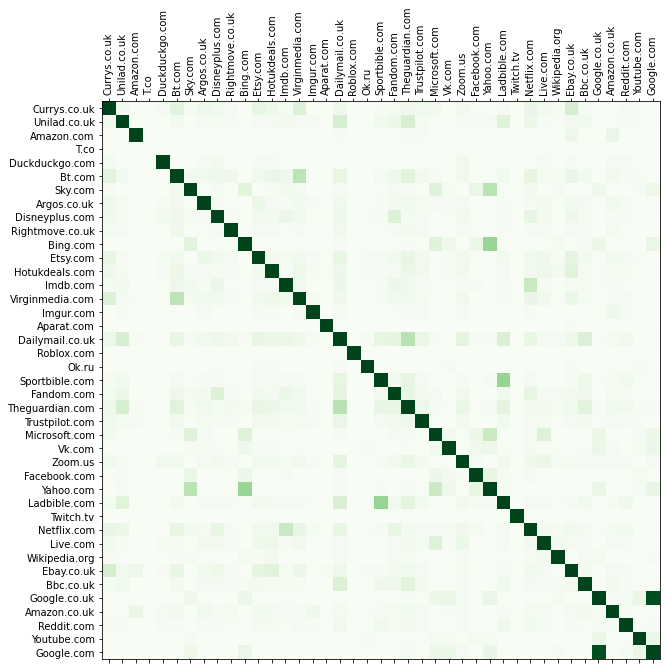

In [25]:

# Initialise class
vectorizer = TfidfVectorizer(analyzer='word', stop_words="english")

# Apply transformation to the corpus
tfidf = vectorizer.fit_transform(corpus)

#Obtain the distance matrix and parse it into a ndarray
distanceArray = (tfidf * tfidf.T).A

#Parse ndarray into a pandas DataFrame
tfidfDF = pd.DataFrame(data=distanceArray, columns=corpusDF.index.tolist(), index=corpusDF.index.tolist())

# Plot DataFrame
plt.figure(figsize=(10,10))
plt.matshow(tfidfDF,cmap="Greens", fignum=1)
ticks = [idx for idx, value in enumerate(tfidfDF.index.tolist())]
ax = plt.gca()

#set the tick labels
xlabels = [txt for i,txt in enumerate(tfidfDF.index.tolist())]
ylabels = [txt for i,txt in enumerate(tfidfDF.index.tolist())]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)
plt.xticks(np.arange(min(ticks), max(ticks)+1, 1.0))
plt.yticks(np.arange(min(ticks), max(ticks)+1, 1.0))
plt.xticks(rotation=90)
plt.show()

From this figure, several outcomes can be obtained: 

* All the sites are identical to themselves (as it is supposed to), except the website *T.co*. This is beacuse of the fact that this specific site contains no words when parsed with `BeautifulSoup`. 
* The sites *Google.com* and *Google.co.uk* are almos identical, since both belong to google and contain similar information and important words (as far as TF-IDF is conerned)

If one searches which sites are more similar, it can be found that:

* The site *LadBible.com* is very similar to the site *SportBible.com*. These sites belong to the same company, and contain the same type of content (one general and one sport-related). 
* The site *Yahoo.com* is very similar to the site *Bing.com*, since they both are search engines. 
* If one knows that the website *Ebay.co.uk* sells products, they can guess that the websites *Currys.co.uk* and *Hotukdeals.com* are used for something similar. If one visits the lattest websites, this is in fact correct, as they both are as well seller websites.
* Another example can be seen with *TheGuardian*. Almost all the websites that are similar to it, are, in fact, websites that offer news (*Dailymail*, *Unilad*, *Bbc*, etc.).


# Conclusions

After analysing the top 50 websites of `Alexa`, it has been seen how, in terms of length of the page, there are some differences between all the websites. However, there are two websites *Dailymail* and *Theguardian* that have a signficiant amount of words more than the other websites (in fact, they are outliers in the boxplot of the wordcount). The other websites do not differ much in the number of words, and are all close to 15000 words.

The analysis of the wordcount per html tag has resulted in a very special case: all the websites have very similar relation of word per html tag. There are no websites in the list that have an incredible amount of word per html tag and none with very few tags per word either.

Visualising the media tags, like `video` and `img` shows which websites have more media content, like *Youtube* and *Netflix*. The `href` has given insight in which websites have more links to other websites (including own links), and in this analysis the site *Wikipedia* has come up with the most links per html tag, given that in a typical *Wikipedia* article, one can found several hundred references to other *Wikipedia* articles, and all the bibliographic references are as well links to other sites.  

The TF-IDF analysis has given a more depth insight. The Term Frequency graphic gives the same information as the analysisi performed with the wordcounts, but it is more clearly visualised, and all the websites are compared to eachother. The TF-IDF figure, however, gives more relevant information. This figure helps us understand which websites are more similar, and therefore it helps us understand what a website that one does not know is used for (selling products, news website, etc.) 

# Further Work

To further widen the analysis of these sites, I would suggest that analysing the websites using the tags and strict wordcounts does not allow us to extract any relevant information about the website, apart from information about the DOM structure (length, tags, etc). Therefore, if other information wants to be extracted from these websites, another source must be considered, in order to link information from such external source to the information that is already available in this notebook. Several improvements and ampliations:

* Obtain the visits total visits to the websites and compare them, obtain more information.
* Compare the websites by type (news, selling, social networks, etc), and extract results of performance
* Try to guess what a website's type is by clustering these websites with the already stored information

# References and resources

All the help to use the packages from this notebook has been gotten from the packages' website. 

* A Practical Introduction to Web Scraping in Python – Real Python. (n.d.). Retrieved January 05, 2021, from https://realpython.com/python-web-scraping-practical-introduction/

* How to Use Tfidftransformer & Tfidfvectorizer - A Short Tutorial | Kavita Ganesan, Ph.D. (n.d.). Retrieved January 05, 2021, from https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X_tB8ulKi3I

* Robertson, S. (2004). Understanding inverse document frequency: On theoretical arguments for IDF. Journal of Documentation, 60(5), 503–520. https://doi.org/10.1108/00220410410560582

* Alexa Rank: Definition and Resources. (n.d.). Retrieved January 05, 2021, from https://blog.alexa.com/marketing-research/alexa-rank/
